## Pdb bind dataset

| Dataset          | Description                                                                                                         | nº of complexes |
|------------------|---------------------------------------------------------------------------------------------------------------------|------------------|
| General dataset  | - Experimentally determined binding affinity                                                                     |                  |
| Refined set      |  (i) the quality of the complex structures Resolution better than 2 A <br> (ii) the quality of the binding data  <br> (iii) the biological/chemical nature of the complex | ~ 5000             |
| Core dataset     |  <br> - As described in the article (Li et al. 2014), the complexes were grouped into clusters based on sequence similarity (90%). <br> - Clusters with fewer than 5 members were ignored. <br> - 3 Complexes from each cluster were chosen based on the affinity constant k_a, max <br> - Electron density maps were analyzed for the "Best, Median, and Poorest" subset of the Core dataset | 285              |


#### Libraries 

In [1]:
import rdkit.Chem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!python --version

Python 3.11.4


#### Functions 

In [3]:
def create_density_plot(data, column_name):
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 3))

    sns.kdeplot(data[column_name], fill=True, color='skyblue', label='Density Plot')

    plt.title(f'Density Plot of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Density')
    plt.legend()

    plt.show()

Python 3.11.4

#### Constantes 

In [4]:
path_to_index = 'PDBbind_meta_dados/refined_dataset/PDBbind_v2020_plain_text_index/index'

In [5]:
index = pd.read_csv(f"{path_to_index}/INDEX_refined_data.2020", sep="\s+", comment="#", header=None).drop(columns = [6,5])
index.columns = [ "PDB code", "resolution", "release year", "-logKd/Ki", "Kd/Ki", "ligand name"]

#### Names 

In [6]:
name = pd.read_csv(f"{path_to_index}/INDEX_refined_name.2020", sep="  ", comment="#", header=None, error_bad_lines=False, names=["PDB code", "Release year", "Uniprot ID", "Protein name"])

/home/lbcb02/anaconda3/envs/master_37/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
/home/lbcb02/anaconda3/envs/master_37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 3896: Expected 4 fields in line 3896, saw 5. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


#### Merging 

###### Metas dados

In [7]:
df = pd.merge(index, name[["PDB code","Uniprot ID","Protein name"]], left_on = "PDB code", right_on = "PDB code", how = "inner")


In [8]:
df.shape

(5315, 8)

In [9]:
df.head()

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,ligand name,Uniprot ID,Protein name
0,2r58,2.00,2007,2.0,Kd=10mM,(MLY),Q9VHA0,POLYCOMB PROTEIN SCM
1,3c2f,2.35,2008,2.0,Kd=10.1mM,(PRP),P43619,NICOTINATE-NUCLEOTIDE PYROPHOSPHORYLASE
2,3g2y,1.31,2009,2.0,Ki=10mM,(GF4),Q9L5C8,BETA-LACTAMASE CTX-M-9A
3,3pce,2.06,1998,2.0,Ki=10mM,(3HP),P00436,"PROTOCATECHUATE 3,4-DIOXYGENASE"
4,4qsu,1.90,2014,2.0,Kd=10mM,(TDR),Q6PL18,ATPASE FAMILY AAA DOMAIN-CONTAINING PROTEIN 2


In [10]:
df['Protein name'].value_counts().head(5)

HIV-1 PROTEASE                      303
CARBONIC ANHYDRASE 2                291
HEAT SHOCK PROTEIN HSP90-ALPHA       94
BROMODOMAIN-CONTAINING PROTEIN 4     69
TRYPSIN                              64
Name: Protein name, dtype: int64

In [11]:
df[df['PDB code'] == "2vxn"]

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,ligand name,Uniprot ID,Protein name
1376,2vxn,0.82,2009,5.0,Kd=10uM,(PGH),P48499,TRIOSEPHOSPHATE ISOMERASE


In [12]:
import os

In [13]:
my_list = os.listdir('/home/lbcb02/Workspace/General data/refined-set')

In [14]:
len(my_list)

5318

#### Completing the missing 'Kd'

In [15]:
df['kd'] = df['Kd/Ki'].apply(lambda x: float(x.split('=')[1][:-2]) if 'Kd' in x else None)
df['ki'] = df['Kd/Ki'].apply(lambda x: float(x.split('=')[1][:-2]) if 'Ki' in x else None)

# Completing the missing 'Kd' values based on '-logKd/Ki' considering units
df['Kd'] = df.apply(lambda row: (10 ** (-row['-logKd/Ki'])) * row['ki'] if pd.isna(row['kd']) else row['kd'], axis=1)

# Multiply 'Kd' by the proper unit
df['Kd'] = df.apply(lambda row: row['Kd'] * 1e-3 if 'mM' in row['Kd/Ki'] else row['Kd'], axis=1)
df['Kd'] = df.apply(lambda row: row['Kd'] * 1e-6 if 'uM' in row['Kd/Ki'] else row['Kd'], axis=1)
df['Kd'] = df.apply(lambda row: row['Kd'] * 1e-9 if 'nM' in row['Kd/Ki'] else row['Kd'], axis=1)

#### Dropping redundancy 

In [16]:
df = df.sort_values(['resolution','Kd'])

In [17]:
df['complex_code'] = df['Protein name'] + "_" + df['ligand name']

In [18]:
df = df.drop_duplicates(subset = 'complex_code', keep = "first")

In [19]:
df['complex_code'].nunique()

4790

In [20]:
df['Protein name'].value_counts()

CARBONIC ANHYDRASE 2                               263
HIV-1 PROTEASE                                     182
HEAT SHOCK PROTEIN HSP90-ALPHA                      87
BROMODOMAIN-CONTAINING PROTEIN 4                    68
TRYPSIN                                             56
                                                  ... 
INORGANIC POLYPHOSPHATE/ATP-NAD KINASE               1
ANTIBODY FAB FRAGMENT, HEAVY CHAIN                   1
ATP-DEPENDENT CLP PROTEASE ADAPTER PROTEIN CLPS      1
GLYCOLIPID TRANSFER PROTEIN                          1
LECTIN CEL-IV, C-TYPE                                1
Name: Protein name, Length: 1411, dtype: int64

In [21]:
df['PDB code'].nunique()

4790

In [22]:
df[['PDB code','Protein name']].to_csv('/home/lbcb02/Workspace/BindRanker/BindRanker/Datahub/Data/depara_pdb_protein_name.csv', index = False)

#### Quandos complexos temos para o modelo? 

In [23]:
df.shape

(4790, 12)

In [24]:
df['complex_code'].nunique()

4790

In [25]:
df['Protein name'].value_counts().head()

CARBONIC ANHYDRASE 2                263
HIV-1 PROTEASE                      182
HEAT SHOCK PROTEIN HSP90-ALPHA       87
BROMODOMAIN-CONTAINING PROTEIN 4     68
TRYPSIN                              56
Name: Protein name, dtype: int64

In [26]:
name = "pdbs_refined_set.csv"

In [27]:
df.head()

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,ligand name,Uniprot ID,Protein name,kd,ki,Kd,complex_code
76,5mn1,0.79,2017,2.48,Kd=3.3mM,(2AP),P00760,TRYPSIN,3.30,NaN,3.300000e-03,TRYPSIN_(2AP)
1376,2vxn,0.82,2009,5.00,Kd=10uM,(PGH),P48499,TRIOSEPHOSPHATE ISOMERASE,10.00,NaN,1.000000e-05,TRIOSEPHOSPHATE ISOMERASE_(PGH)
4537,2hs1,0.84,2006,8.48,Ki=3.3nM,(017),P03368,HIV-1 PROTEASE,NaN,3.3,1.092733e-17,HIV-1 PROTEASE_(017)
2379,4ayp,0.85,2013,6.12,Kd=755nM,(SMD),B0SWV2,"MANNOSYL-OLIGOSACCHARIDE 1,2-ALPHA-MANNOSIDASE",755.00,NaN,7.550000e-07,"MANNOSYL-OLIGOSACCHARIDE 1,2-ALPHA-MANNOSIDASE..."
1883,4tkb,0.86,2015,5.59,Kd=2.56uM,(DAO),P05413,FATTY ACID-BINDING PROTEIN,2.56,NaN,2.560000e-06,FATTY ACID-BINDING PROTEIN_(DAO)


In [28]:
df['PDB code'].to_csv(f"../Datahub/{name}", index =False)

In [33]:
pdb = pd.read_csv(f"../Datahub/{name}")

In [40]:
'3mv0' in list(pdb['PDB code'])

False

In [29]:
dataset = df.groupby(['Protein name'])['ligand name'].value_counts().reset_index(name='count').sort_values(['count'])

In [30]:
dataset[dataset['count'] > 1].shape

(0, 3)

**274 Complexos com mais de uma repetição!** 

In [31]:
dataset[dataset['count'] > 1].head()

,Protein name,ligand name,count


In [32]:
#df.groupby("Protein name")['resolution'].value_counts()
#df.groupby("Protein name")['-logKd/Ki'].value_counts().sort_values(ascending = False).head()
#df.groupby("PDB code")['ligand name'].value_counts().sort_values(0, ascending = False).head()

#### Metadata

 "-log(Kd/Ki)" refers to the negative logarithm of the ratio of dissociation constant (Kd) to the inhibition constant (Ki). 
 * Kd represents the equilibrium dissociation constant, which quantifies the strength of the interaction between a ligand and its target by measuring the concentration of ligand required to achieve 50% dissociation from the target. 
 * Ki, on the other hand, represents the inhibition constant, which quantifies the ability of a ligand to inhibit the activity of the target.

The ratio Kd/Ki is a measure of the binding affinity. 
*  __A lower Kd/Ki value indicates a stronger binding affinity__, implying that the ligand has a higher likelihood of effectively interacting with the target and modulating its function.
* __The negative logarithm of this ratio, -log(Kd/Ki), is often used to express the binding affinity on a logarithmic scale, where a higher value indicates a stronger binding.__


#### Core dataset

In [40]:
comp = pd.read_csv("complexes.csv")[["PDB","Missing data | Pocket","Metals | Pocket"]]
comp["Missing data | Pocket"] = comp["Missing data | Pocket"].str.strip()
comp['PDB'] = comp['PDB'].astype("str")

In [41]:
comp.head(2)

,PDB,Missing data | Pocket,Metals | Pocket
0,1a30,Não,NaN
1,1bcu,Sim,NaN


In [42]:
comp['PDB'].nunique()

285

#### General info 

In [1]:
#comp["Missing data | Pocket"].value_counts()

In [2]:
#comp["Metals | Pocket"].value_counts(dropna = False)

#### Merging everthing 

<font color = yellow> Warning! 23 pdbs without info! 

In [45]:
len(set(comp["PDB"]) - set(df["PDB code"]))

27

In [46]:
data = pd.merge(df, comp, left_on = "PDB code", right_on = "PDB", how = "right")

In [47]:
data['PDB'].nunique()

285

In [49]:
data['Protein name'].value_counts()

HIV-1 PROTEASE                                      5
RNA-DIRECTED RNA POLYMERASE                         5
ENDOTHIAPEPSIN                                      5
BETA-SECRETASE 1                                    5
THROMBIN                                            5
ACETYLCHOLINE RECEPTOR                              5
SERINE/THREONINE-PROTEIN KINASE 6                   5
ALPHA-L-FUCOSIDASE                                  5
3-DEHYDROQUINATE DEHYDRATASE                        5
DEHYDROSQUALENE SYNTHASE                            5
HIV-1 INTEGRASE                                     5
PANTOTHENATE SYNTHETASE                             5
PEROXISOME PROLIFERATOR-ACTIVATED RECEPTOR GAMMA    5
MACROPHAGE METALLOELASTASE (MMP-12)                 5
TANKYRASE-2                                         5
BETA-LACTOGLOBULIN                                  5
BROMODOMAIN-CONTAINING PROTEIN 4                    5
ACETYLCHOLINE-BINDING PROTEIN                       5
CGMP 3',5'-CYCLIC PHOSPHODIE

#### Saving data 

In [68]:
name = "coreset_all_285.csv"

In [107]:
data.to_csv(f"../Datahub/{name}")

In [50]:
data.groupby(['Protein name'])['ligand name'].value_counts().reset_index(name = "count").head()

,Protein name,ligand name,count
0,3-DEHYDROQUINATE DEHYDRATASE,(CA2),1
1,3-DEHYDROQUINATE DEHYDRATASE,(FA1),1
2,3-DEHYDROQUINATE DEHYDRATASE,(RJP),1
3,3-DEHYDROQUINATE DEHYDRATASE,(XH2),1
4,3-DEHYDROQUINATE DEHYDRATASE,(XNW),1


In [136]:
#data.groupby("Protein name")["PDB code"].nunique().head()

In [137]:
#data.groupby('Protein name')['Posição residuos faltantes'].value_counts().head(20)

In [138]:
#data.head(2)

In [139]:
#data.groupby(["Protein name",'Missing residues'])[['Missing residues']].count().head(60)

In [140]:
#data.sort_values("Protein name")[['Protein name','Posição residuos faltantes']].head(50)

#### Report data availabity 

| Dataset          | Description                                                                                                         | nº of complexes |
|------------------|---------------------------------------------------------------------------------------------------------------------|------------------|
| General dataset  | - Experimentally determined binding affinity                                                                     |                  |
| Refined set      |  (i) the quality of the complex structures Resolution better than 2 A <br> (ii) the quality of the binding data  <br> (iii) the biological/chemical nature of the complex | ~ 5000             |
| Core dataset     |  <br> - As described in the article (Li et al. 2014), the complexes were grouped into clusters based on sequence similarity (90%). <br> - Clusters with fewer than 5 members were ignored. <br> - 3 Complexes from each cluster were chosen based on the affinity constant k_a, max <br> - Electron density maps were analyzed for the "Best, Median, and Poorest" subset of the Core dataset | 285              |


#### Refined set

| Information: Refined set                      | Value  |
|-----------------------------------------------|--------|
| Initial complexes qtd                          | 5315   |
| qtd uniques (protein_name_ligand_name) complexes | 4790   |
| Complexos com pelo menos 2 aparições            | 274    |


In [35]:
df.head()

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,ligand name,Uniprot ID,Protein name,complex_code
0,2r58,2.00,2007,2.0,Kd=10mM,(MLY),Q9VHA0,POLYCOMB PROTEIN SCM,POLYCOMB PROTEIN SCM_(MLY)
1,3c2f,2.35,2008,2.0,Kd=10.1mM,(PRP),P43619,NICOTINATE-NUCLEOTIDE PYROPHOSPHORYLASE,NICOTINATE-NUCLEOTIDE PYROPHOSPHORYLASE_(PRP)
2,3g2y,1.31,2009,2.0,Ki=10mM,(GF4),Q9L5C8,BETA-LACTAMASE CTX-M-9A,BETA-LACTAMASE CTX-M-9A_(GF4)
3,3pce,2.06,1998,2.0,Ki=10mM,(3HP),P00436,"PROTOCATECHUATE 3,4-DIOXYGENASE","PROTOCATECHUATE 3,4-DIOXYGENASE_(3HP)"
4,4qsu,1.90,2014,2.0,Kd=10mM,(TDR),Q6PL18,ATPASE FAMILY AAA DOMAIN-CONTAINING PROTEIN 2,ATPASE FAMILY AAA DOMAIN-CONTAINING PROTEIN 2_...


In [35]:
df.tail()

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,ligand name,Uniprot ID,Protein name
1285,3pju,2.5,2011,4.88,Kd=13.1uM,(C2E),Q3KK31,CYCLIC DIMERIC GMP BINDING PROTEIN
4476,1aaq,2.5,1994,8.40,Ki=4.0nM,(PSI),Q8Q3J5,HIV-1 PROTEASE
4820,1y0l,2.5,2005,9.00,Kd=1nM,(HAN),------,"ANTIBODY FAB 34E4, LIGHT CHAIN"
3650,1drj,2.5,1995,7.40,Kd=0.040uM,(RIP),P02925,D-RIBOSE-BINDING PROTEIN
4761,4gj3,2.5,2013,8.85,Ki=1.4nM,(0XP),P29597,NON-RECEPTOR TYROSINE-PROTEIN KINASE TYK2


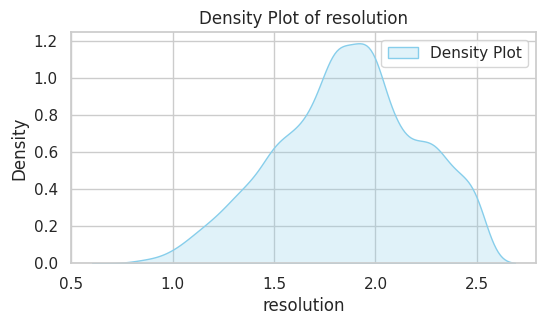

In [52]:
create_density_plot(df, 'resolution')

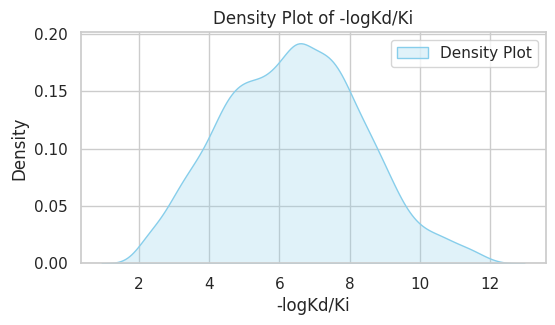

In [55]:
create_density_plot(df, '-logKd/Ki')

<AxesSubplot:>

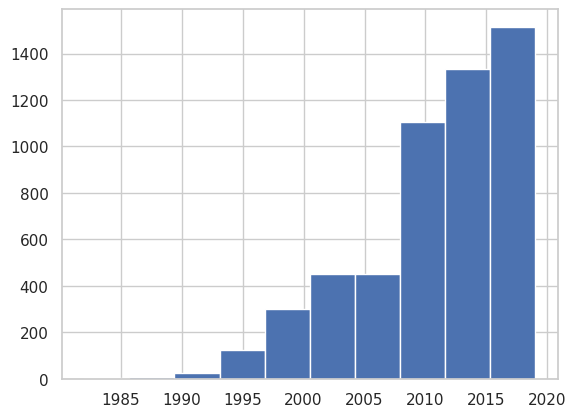

In [61]:
df['release year'].hist()

1 passo 
 -  Ver se os metais são da proteína ou não, olhano o cabeçalho da proteína????

https://pymolwiki.org/index.php/Centerofmass#:~:text=The%20centerofmass%20command%20calculates%20the,considers%20atom%20mass%20and%20occupancy.

In [26]:
"https://proteins.plus/"

'https://proteins.plus/'

#### Anotações 

* 2 anéis com espaçador (6 carbonos, hidrogênio)
    * não podem estar no mesmo plano, um deles gira
 
* Anel com 4 carbonos e 1 nitrogênio, plano
* anel com 5 carbonos e 1 nitrogênio, plano

* 3ehy
  - Mesa: hidrogênio da ponta, tem que apontar para baixo, e o enxofre tbm, um de cada lado.
  - só desce se for o hidrogênio
* 3kwa:
  - Olhar emenda de hidrogênios, falso anel

* Tem um clash no 3nw9 com o metal, porque marcamos como azul;
* Porque marcamos o 3ozs com vermelho ?  

* 1c5z porque não tem hidrogênios no anel 